In [1]:
import cv2
import os
import numpy as np

In [2]:
def extract_frames_from_videos(video_dir, output_dir, frame_rate=5):
    """Extract frames from videos and save them into subdirectories based on the video category."""
    class_names = ['LegalBall','NoBall']  # Define class labels

    for class_name in class_names:
        class_folder = os.path.join(video_dir, class_name)
        output_class_dir = os.path.join(output_dir, 'extracted_frames', class_name)
        os.makedirs(output_class_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        for video_file in os.listdir(class_folder):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_folder, video_file)
                video = cv2.VideoCapture(video_path)
                success, image = video.read()
                frame_count = 0
                while success:
                    if frame_count % frame_rate == 0:  # Capture frame at specific intervals
                        frame_filename = f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                        frame_output_path = os.path.join(output_class_dir, frame_filename)
                        image_resized = cv2.resize(image, (224, 224))  # Resize for CNN
                        cv2.imwrite(frame_output_path, image_resized)  # Save frame
                    success, image = video.read()
                    frame_count += 1

In [3]:
video_dir = 'NoBall/'  # Path to your dataset directory 
output_dir = 'NoBall/data/'  # Root directory where all data will be saved

In [4]:
extract_frames_from_videos(video_dir, output_dir)

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

In [6]:
def load_data_from_frames(output_dir):
    """Load frames from directories and prepare the data for training."""
    class_names = ['LegalBall','NoBall']
    data = []
    labels = []

    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(output_dir, 'extracted_frames', class_name)
        for frame_file in os.listdir(class_folder):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(class_folder, frame_file)
                image = cv2.imread(frame_path)
                data.append(image)
                labels.append(class_id)  # Assign class label

    data = np.array(data)
    labels = np.array(labels)
    
    # Normalize the frames
    data = data.astype('float32') / 255.0
    
    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=4)

    return data, labels


In [7]:
# Load frames and labels
frames_data, labels_data = load_data_from_frames(output_dir)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(frames_data, labels_data, test_size=0.2, random_state=42)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define the model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN part wrapped in TimeDistributed (to apply the CNN to each frame)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    # LSTM part
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer (4 classes: No Ball, Legal Ball, Wide, LBW)
    model.add(Dense(4, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Define the input shape: (10 frames, 224x224 pixels, 3 color channels)
input_shape = (10, 224, 224, 3)
model = create_cnn_lstm_model(input_shape)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 222, 222, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 222, 222, 32)    │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 111, 111, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 109, 109, 64)    │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 109, 109, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 54, 54, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 52, 52, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 52, 52, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 26, 26, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 86528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │      22,167,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,270,788 (84.96 MB)

 Trainable params: 22,270,340 (84.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Data augmentation (to reduce overfitting and introduce more data variety)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [14]:
# Apply augmentation frame by frame before creating sequences
def augment_frames(X_train):
    augmented_frames = []
    for frame in X_train:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return np.array(augmented_frames)


In [15]:
# Function to create frame sequences for the model
def create_frame_sequences(data, labels, sequence_length=10):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(data) - sequence_length, sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Use the label of the last frame in the sequence
    
    return np.array(sequences), np.array(sequence_labels)

In [16]:
# Example data (X_train, y_train) should be processed with your dataset
# Assuming X_train and y_train are preprocessed
# Manually augment data frame by frame
X_train_augmented = augment_frames(X_train)

In [17]:
# Group the frames into sequences of 10 frames each
X_train_seq, y_train_seq = create_frame_sequences(X_train_augmented, y_train, sequence_length=10)
X_test_seq, y_test_seq = create_frame_sequences(X_test, y_test, sequence_length=10)

In [18]:
# Define learning rate scheduler and checkpoint
checkpoint = ModelCheckpoint('no_ball_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [19]:
# Train the model using the sequences of frames
history = model.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=4,
                    validation_data=(X_test_seq, y_test_seq),
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5421 - loss: 1.1013
Epoch 1: val_loss improved from inf to 0.85735, saving model to no_ball_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5487 - loss: 1.0900 - val_accuracy: 0.9000 - val_loss: 0.8573 - learning_rate: 1.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8254 - loss: 0.7189
Epoch 2: val_loss improved from 0.85735 to 0.36884, saving model to no_ball_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.8252 - loss: 0.7151 - val_accuracy: 0.9000 - val_loss: 0.3688 - learning_rate: 1.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8167 - loss: 0.5799
Epoch 3: val_loss improved from 0.36884 to 0.30516, saving model to no_ball_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.8157 - loss: 0.5809 - val_accuracy: 0.9500 - val_loss: 0.3052 - learning_rate: 1.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy

In [20]:
import pandas as pd

In [21]:
# Create the logs directory
logs_dir = os.path.join(output_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [22]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

In [23]:
# Save the training history to CSV
log_file_path = os.path.join(logs_dir, 'training_log.csv')
history_df.to_csv(log_file_path, index=False)

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

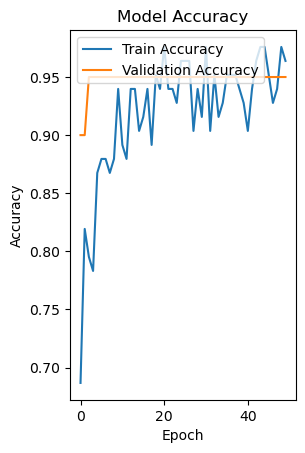

In [26]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

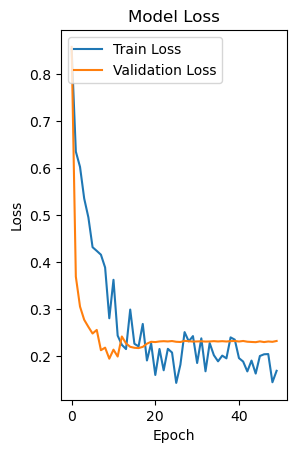

In [27]:
# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [29]:
from tensorflow.keras.models import load_model

In [30]:
# Load the saved model
model = load_model('no_ball_model.keras')

In [31]:
import cv2
import numpy as np

In [32]:
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame to the size expected by the model (frame_size)
        frame_resized = cv2.resize(frame, frame_size)
        
        # Optionally normalize the frame (if required by the model)
        frame_normalized = frame_resized / 255.0  # Example for normalization
        
        frames.append(frame_normalized)

        # Skip frames to match the desired frame rate (if needed)
        # if frame_count % frame_rate == 0:
        #     frames.append(frame_normalized)
    
    cap.release()
    
    # Convert the list of frames to a numpy array
    frames = np.array(frames)

    # Make sure the shape of the frames matches the input shape of the model
    return frames

In [33]:
# Example usage
video_path = 'Test_Video_Data/noballs1.mp4'
video_frames = preprocess_video(video_path)

In [34]:
# Make prediction on the processed frames
prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [35]:
# If the model outputs probabilities, decide on the threshold
threshold = 0.5
no_ball = prediction[0][0] > threshold

In [36]:
if no_ball:
    print("The video is classified as No Ball.")
else:
    print("The video is classified as Leagal Ball.")

The video is classified as No Ball.


# Model Evaluation

## recall_score, precision_score, f1_score, accuracy_score

In [8]:
import os
import numpy as np
import cv2
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('no_ball_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    """
    Preprocess the input video to extract frames and resize them for the model.
    If the video has fewer frames than `sequence_length`, pad with zeros (empty frames).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize the frame
        frames.append(frame_normalized)
    
    cap.release()

    # Check if no frames were read
    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))  # Return a placeholder of zeros
    
    # If there are fewer frames than required, pad with empty frames (zeros)
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    # If there are more frames, truncate to the required sequence length
    frames = frames[:sequence_length]

    # Convert the frames list to a numpy array with shape (sequence_length, height, width, channels)
    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    """
    Evaluate the model on a dataset and compute the classification metrics.
    """
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)
                
                # Preprocess the video to get the sequence of frames
                video_frames = preprocess_video(video_path, sequence_length=sequence_length)
                
                # Make prediction
                prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension
                threshold = 0.5
                predicted_label = 1 if prediction[0][1] > threshold else 0
                
                # Ground truth based on the folder name
                ground_truth = 1 if class_name == "NoBall" else 0
                
                # Append true and predicted labels
                y_true.append(ground_truth)
                y_pred.append(predicted_label)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# Path to your dataset
dataset_path = 'NoBall'  # Update this path

# Evaluate the model and print the metrics
accuracy, precision, recall, f1 = evaluate_model(dataset_path, sequence_length=10)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## ROC Curve and AUC

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

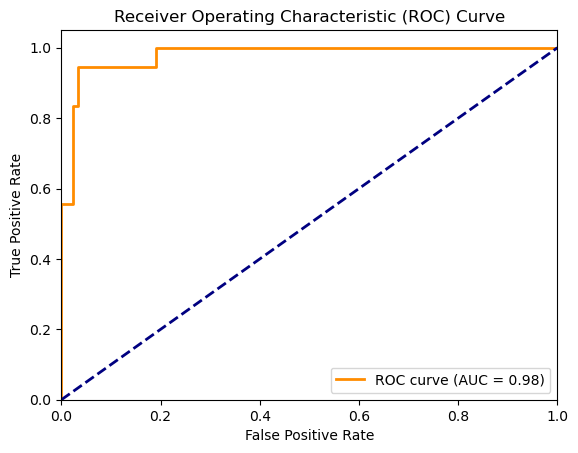

AUC: 0.98


In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('no_ball_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    """
    Preprocess the input video to extract frames and resize them for the model.
    If the video has fewer frames than `sequence_length`, pad with zeros (empty frames).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize the frame
        frames.append(frame_normalized)
    
    cap.release()

    # Check if no frames were read
    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))  # Return a placeholder of zeros
    
    # If there are fewer frames than required, pad with empty frames (zeros)
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    # If there are more frames, truncate to the required sequence length
    frames = frames[:sequence_length]

    # Convert the frames list to a numpy array with shape (sequence_length, height, width, channels)
    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    """
    Evaluate the model on a dataset and compute the ROC curve and AUC.
    """
    y_true = []  # Ground truth labels
    y_pred_probs = []  # Predicted probabilities
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)
                
                # Preprocess the video to get the sequence of frames
                video_frames = preprocess_video(video_path, sequence_length=sequence_length)
                
                # Get prediction probabilities
                prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension
                predicted_prob = prediction[0][1]  # Probability for the "NoBall" class
                
                # Ground truth based on the folder name
                ground_truth = 1 if class_name == "NoBall" else 0
                
                # Append true labels and predicted probabilities
                y_true.append(ground_truth)
                y_pred_probs.append(predicted_prob)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    auc = roc_auc_score(y_true, y_pred_probs)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return fpr, tpr, auc

# Path to your dataset
dataset_path = 'NoBall'  # Update this path

# Evaluate the model and get the ROC curve and AUC
fpr, tpr, auc = evaluate_model(dataset_path, sequence_length=10)
print(f"AUC: {auc:.2f}")


## Confusion Matrix

Class Weights: {0: 0.601123595505618, 1: 2.9722222222222223}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━

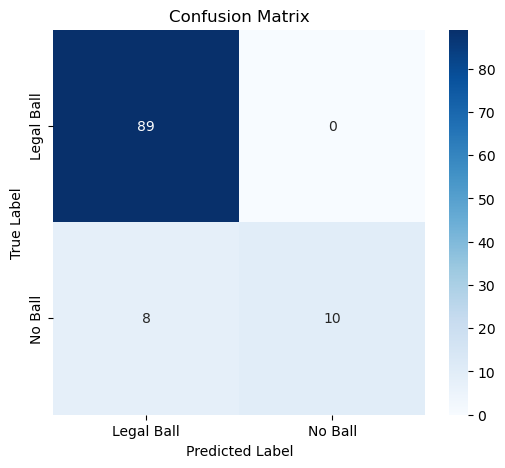

Accuracy: 0.9252336448598131
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
[[89  0]
 [ 8 10]]


In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# Load the saved model
model = load_model('no_ball_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    """
    Preprocess the input video to extract frames and resize them for the model.
    If the video has fewer frames than `sequence_length`, pad with zeros (empty frames).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize the frame
        frames.append(frame_normalized)
    
    cap.release()

    # Check if no frames were read
    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))  # Return a placeholder of zeros
    
    # If there are fewer frames than required, pad with empty frames (zeros)
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    # If there are more frames, truncate to the required sequence length
    frames = frames[:sequence_length]

    # Convert the frames list to a numpy array with shape (sequence_length, height, width, channels)
    frames = np.array(frames)

    return frames

def calculate_class_weights(dataset_path):
    """
    Calculate class weights based on the frequency of each class in the dataset.
    """
    # Initialize counters for each class
    class_counts = {'NoBall': 0, 'LegalBall': 0}
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)
                # Count the occurrence of each class
                if class_name == "NoBall":
                    class_counts['NoBall'] += 1
                else:
                    class_counts['LegalBall'] += 1
    
    # Calculate the class weights based on the counts
    class_labels = np.array([0, 1])  # Convert to numpy ndarray
    class_weights = compute_class_weight('balanced', classes=class_labels, y=np.array(
        [0] * class_counts['LegalBall'] + [1] * class_counts['NoBall']
    ))
    
    # Return a dictionary of class weights
    return dict(zip(class_labels, class_weights))

def evaluate_model(dataset_path, sequence_length=10):
    """
    Evaluate the model on a dataset and compute the confusion matrix.
    """
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    
    # Calculate class weights
    class_weights = calculate_class_weights(dataset_path)
    print(f"Class Weights: {class_weights}")
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)
                
                # Preprocess the video to get the sequence of frames
                video_frames = preprocess_video(video_path, sequence_length=sequence_length)
                
                # Get prediction probabilities
                prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension
                predicted_prob = prediction[0][1]  # Probability for the "NoBall" class
                
                # Convert probability to predicted class (0 or 1)
                predicted_label = 1 if predicted_prob > 0.5 else 0
                
                # Ground truth based on the folder name
                ground_truth = 1 if class_name == "NoBall" else 0
                
                # Append true and predicted labels
                y_true.append(ground_truth)
                y_pred.append(predicted_label)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Legal Ball', 'No Ball'], yticklabels=['Legal Ball', 'No Ball'])
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate the other metrics for performance evaluation
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

# Path to your dataset
dataset_path = 'NoBall'  # Update this path

# Evaluate the model and print the metrics
accuracy, precision, recall, f1, cm = evaluate_model(dataset_path, sequence_length=10)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")


## Matthews Correlation Coefficient (MCC)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

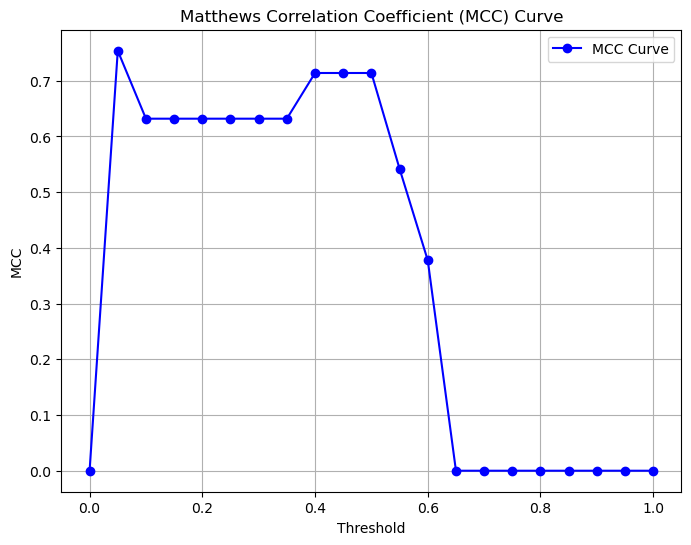

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('no_ball_model.keras')

def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30, sequence_length=10):
    """
    Preprocess the input video to extract frames and resize them for the model.
    If the video has fewer frames than `sequence_length`, pad with zeros (empty frames).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize the frame
        frames.append(frame_normalized)
    
    cap.release()

    # Check if no frames were read
    if len(frames) == 0:
        print(f"Warning: No frames read from video: {video_path}")
        return np.zeros((sequence_length, *frame_size, 3))  # Return a placeholder of zeros
    
    # If there are fewer frames than required, pad with empty frames (zeros)
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(frames[0])] * (sequence_length - len(frames)))
    # If there are more frames, truncate to the required sequence length
    frames = frames[:sequence_length]

    # Convert the frames list to a numpy array with shape (sequence_length, height, width, channels)
    frames = np.array(frames)

    return frames

def evaluate_model(dataset_path, sequence_length=10):
    """
    Evaluate the model on a dataset and compute the confusion matrix and MCC.
    """
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for video_name in os.listdir(class_folder):
                video_path = os.path.join(class_folder, video_name)
                
                # Preprocess the video to get the sequence of frames
                video_frames = preprocess_video(video_path, sequence_length=sequence_length)
                
                # Get prediction probabilities
                prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension
                predicted_prob = prediction[0][1]  # Probability for the "NoBall" class
                
                # Convert probability to predicted class (0 or 1)
                predicted_label = 1 if predicted_prob > 0.5 else 0
                
                # Ground truth based on the folder name
                ground_truth = 1 if class_name == "NoBall" else 0
                
                # Append true and predicted labels
                y_true.append(ground_truth)
                y_pred.append(predicted_label)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Legal Ball', 'No Ball'], yticklabels=['Legal Ball', 'No Ball'])
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate the other metrics for performance evaluation
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate the Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)

    return accuracy, precision, recall, f1, mcc, cm

# Path to your dataset
dataset_path = 'NoBall'  # Update this path

# Evaluate the model and print the metrics
accuracy, precision, recall, f1, mcc, cm = evaluate_model(dataset_path, sequence_length=10)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"MCC: {mcc}")
print(f"Confusion Matrix:\n{cm}")
